In [1]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
pip install torch torchvision opencv-python yt-dlp

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   --------------------------------- ------ 2.6/3.2 MB 15.1 MB/s eta 0:00:01
   ---------------------------------------- 3.2/3.2 MB 14.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ultralytics deep-sort-realtime

   ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
   ----------------- ---------------------- 3.7/8.4 MB 19.8 MB/s eta 0:00:01
   ---------------------------------------- 8.4/8.4 MB 22.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import subprocess
import torch
import torchvision
from torchvision.transforms import functional as F
from ultralytics import YOLO
import cv2
from deep_sort_realtime.deepsort_tracker import DeepSort

In [ ]:
#Downloading video at the highest resolution
video_url = "https://www.youtube.com/watch?v=l3NJNFmg09k&t=6s"
result = subprocess.run(
    ["yt-dlp", "-f", "bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4", video_url, "-o", "video_best.mp4"],
    capture_output=True,
    text=True
)

if result.returncode != 0:
    print("Error downloading video:", result.stderr)
else:
    print("Video downloaded!")

Video downloaded!


In [5]:
#COCO 80 class list
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'TV', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


In [6]:
#Classes to be detected
target_classes = ['person', 'sports ball']
target_class_indices = [COCO_INSTANCE_CATEGORY_NAMES.index(cls) for cls in target_classes]
target_class_indices

[1, 33]

In [ ]:
# Load video
cap = cv2.VideoCapture("video_best.mp4")

#Create empty output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_FasterRCNN.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Faster RCNN obj det

In [7]:
#Pretrained FasterRCNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
model.eval() 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
#FasterRCNN inference on video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    #Convert frame to tensor and make prediction
    img_tensor = F.to_tensor(frame).unsqueeze(0)
    with torch.no_grad():
        detections = model(img_tensor)[0]

    #Target class detections filtering
    for i, score in enumerate(detections['scores']):
        if score >= 0.5 and detections['labels'][i].item() in target_class_indices:
            label = COCO_INSTANCE_CATEGORY_NAMES[detections['labels'][i].item()]
            box = detections['boxes'][i].numpy()
            confidence = score.item()

            #Draw bounding box around detected objects
            cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'{label} ({confidence:.2f})', 
                        (int(box[0]), int(box[1]) - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (0, 255, 0), 2)

    #Write frame to output video
    out.write(frame)

    #Real time frame display 
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [ ]:
cap.release()
out.release()
cv2.destroyAllWindows()

# Yolov8 obj det

In [ ]:
#Pretrained YOLO v8 model
model =  YOLO('yolov8s.pt')
model.info()

YOLOv8s summary: 225 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)

In [ ]:
# Load video
cap = cv2.VideoCapture("video_best.mp4")

#Create empty output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_Yolov8s.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

In [ ]:
#Yolov8 object detection
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    #YOLO inference on the frame
    results = model(frame)

    #Target class detections filtering
    for result in results[0].boxes.data:
        x1, y1, x2, y2, confidence, cls = result.tolist()
        label = model.names[int(cls)]
        
        #Draw bounding box around detected objects
        if label in ['person', 'sports ball'] and confidence >= 0.5:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f'{label} ({confidence:.2f})', 
                        (int(x1), int(y1) - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (0, 255, 0), 2)

    #Write frame to output video
    out.write(frame)

    #Real time frame display
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


0: 384x640 8 persons, 122.6ms
Speed: 44.7ms preprocess, 122.6ms inference, 62.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 95.8ms
Speed: 2.4ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 86.7ms
Speed: 1.0ms preprocess, 86.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 89.3ms
Speed: 1.3ms preprocess, 89.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 87.5ms
Speed: 1.5ms preprocess, 87.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 88.9ms
Speed: 1.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 91.5ms
Speed: 1.3ms prep

In [ ]:
cap.release()
out.release()
cv2.destroyAllWindows()

# DeepSort with YOLOv8

## DeepSort Architecture block diagram  
<!-- ![DeepSORT Architecture](Architecture.png)
<img src="Architecture.png" width="800" /> -->
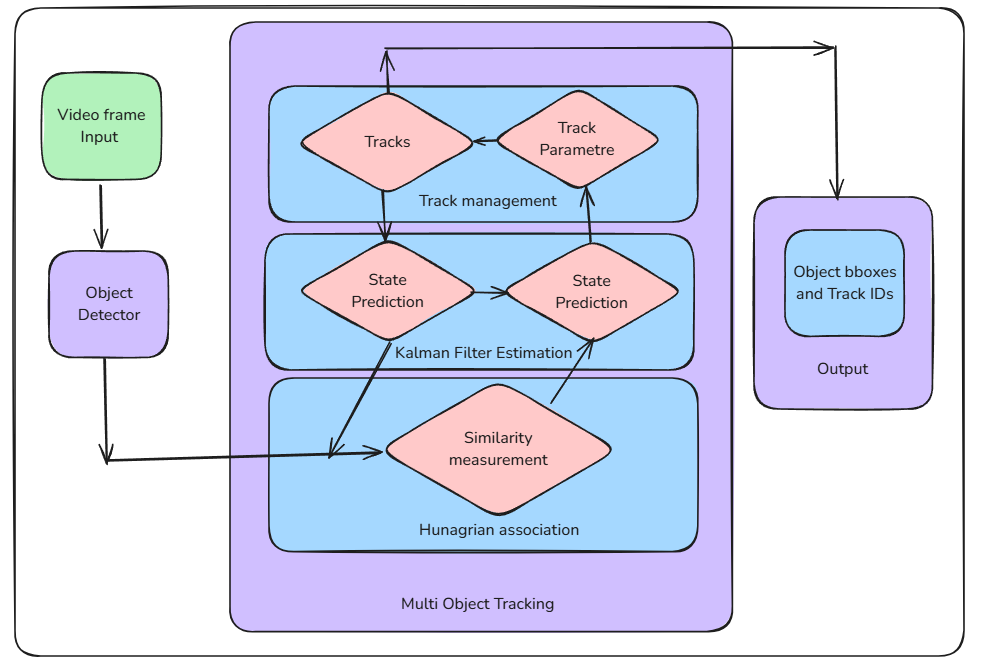

## Multi object tracking with DeepSort workflow:  

1. Object Detection: An object detection model generates detection boxes, class labels, and confidence scores for each frame.
2. Object Tracking:   
    a. Kalman Filter: Predicts the next state of objects (position and velocity) based on motion models.  
    b. Association Step: Matches detected objects to predicted object tracks using the Hungarian Algorithm and Intersection over Union (IoU).  
    c. Tracks Management: Manages tracked objects, including adding new tracks, updating existing ones, and deleting outdated tracks.  

## Kalman Filter: 
Module to predict and update state space vector

I. **Initialization**  

The state vector is defined as:  
$$  
\mathbf{x}_k =   
\begin{bmatrix}  
x \\
y \\
v_x \\
v_y  
\end{bmatrix}  
$$  

Where:  
- `x`, `y` are the positions,  
- `v_x` and `v_y` are the velocities.  

The state transition model is given by:  
$$  
\mathbf{F} =  
\begin{bmatrix}  
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1  
\end{bmatrix}  
$$  

Where `dt` is the time step between frames.  
<br>

II. **Prediction Step**  

1. **Predict the state:**  
$$  
\mathbf{x}_{k|k-1} = \mathbf{F} \cdot \mathbf{x}_{k-1|k-1}  
$$  

2. **Predict the covariance:**  
$$  
\mathbf{P}_{k|k-1} = \mathbf{F} \cdot \mathbf{P}_{k-1|k-1} \cdot \mathbf{F}^T + \mathbf{Q}  
$$  

Where `Q`  is the process noise covariance matrix.  
<br>   

III. **Update Step**  

1. **Compute the Kalman Gain:**  
$$  
\mathbf{K}_k = \mathbf{P}_{k|k-1} \cdot \mathbf{H}^T \cdot \left(\mathbf{H} \cdot \mathbf{P}_{k|k-1} \cdot \mathbf{H}^T + \mathbf{R}\right)^{-1}  
$$  

Where `H` is the measurement matrix and `R` is the measurement noise covariance matrix.  

2. **Update the state:**  
$$  
\mathbf{x}_{k|k} = \mathbf{x}_{k|k-1} + \mathbf{K}_k \cdot \left(\mathbf{z}_k - \mathbf{H} \cdot \mathbf{x}_{k|k-1}\right)  
$$  

Where `zk`  is the measurement vector.  

3. **Update the covariance:**  
$$  
\mathbf{P}_{k|k} = \left(\mathbf{I} - \mathbf{K}_k \cdot \mathbf{H}\right) \cdot \mathbf{P}_{k|k-1}  
$$  

Where `I` is the identity matrix.


## Hunagrian Algorithm: 
Algorithm to solve assignment problem in polynomial time
 

Let `C` be a cost matrix where `C_ij` is the cost of assigning task `j` to worker  `i`.  

I. **Problem Formulation**  

The goal is to minimize the total cost of assignments:  

$$  
\text{Minimize} \quad Z = \sum_{i=1}^{n} \sum_{j=1}^{n} C_{ij} x_{ij}  
$$  

Subject to the constraints:  

$$  
\sum_{j=1}^{n} x_{ij} = 1 \quad \forall i \in \{1, 2, \ldots, n\}  
$$  

$$  
\sum_{i=1}^{n} x_{ij} = 1 \quad \forall j \in \{1, 2, \ldots, n\}  
$$  

$$  
x_{ij} \in \{0, 1\} \quad \forall i, j  
$$  

II. **Hungarian Algorithm**  

1. **Row Reduction:**  
   $$  
   C'_{ij} = C_{ij} - \min_j C_{ij}  
   $$  

2. **Column Reduction:**  
   $$  
   C''_{ij} = C'_{ij} - \min_i C'_{ij}  
   $$  

3. **Covering Zeros:** Cover all zeros in the matrix using a minimum number of horizontal and vertical lines.  

4. **Adjusting the Matrix:**  

   Let   
   $$  
   \text{min\_uncovered} = \min_{(i,j) \text{ not covered}} C'_{ij}  
   $$  
   
   Update the matrix:  
   $$  
   C''_{ij} = C''_{ij} - \text{min\_uncovered} \quad \text{(for uncovered elements)}  
   $$  
   $$  
   C''_{ij} = C''_{ij} + \text{min\_uncovered} \quad \text{(for elements covered twice)}  
   $$  



In [ ]:
# Load video
cap = cv2.VideoCapture("video_best.mp4")

#Create empty output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_Yolov8s_deepsort.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

In [ ]:
#Instantiate tracker
tracker = DeepSort(max_age=30)

#Read in video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    #YOLOv8 inference on frame
    detections = model(frame)[0]
    results = []

    #Parse YOLO output and entered filtered information into results
    for data in detections.boxes.data.tolist():
        confidence = data[4]
        if float(confidence) >= 0.5:
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            class_id = int(data[5])

            #Convert from YOLO to Deepsort compatible format
            results.append([[xmin, ymin, xmax - xmin, ymax - ymin], confidence, class_id])

    #Update tracker with frame
    tracks = tracker.update_tracks(results, frame=frame)

    #Loop over tracks
    for track in tracks:
        if not track.is_confirmed(): 
            continue

        track_id = track.track_id
        #Convert track back to [xmin, ymin, xmax, ymax]
        ltrb = track.to_ltrb()
        xmin, ymin, xmax, ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])

        #Define targte class labels to print
        if class_id==0:
            label = 'person'
        elif class_id==32:
            label = 'football'

        #Draw bbox, class label and track ID on frame
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.rectangle(frame, (xmin, ymin - 20), (xmin + len(f'{label} {str(track_id)}') * 10, ymin), (0, 255, 0), -1)
        cv2.putText(frame, f'{label} {str(track_id)}', (xmin + 5, ymin - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    #Write frame to output video
    out.write(frame)

    #Real time frame display
    cv2.imshow("Frame", frame)


0: 384x640 8 persons, 95.6ms
Speed: 3.0ms preprocess, 95.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 102.3ms
Speed: 3.0ms preprocess, 102.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 90.9ms
Speed: 1.0ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 89.2ms
Speed: 1.0ms preprocess, 89.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 101.9ms
Speed: 2.0ms preprocess, 101.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 89.5ms
Speed: 2.3ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 111.4ms
Speed: 3.0ms pre

In [28]:
cap.release()
out.release()
cv2.destroyAllWindows()